In [3]:
import simpy
import numpy as np
import functools
import matplotlib.pyplot as plt
from Stats import Entity, Resource, Source

## Description of problem: 

You have to model a restaurant.

They must order. The Kitchen is described as follows: 
 - 2 cooks
 - 3 things to order:
   - fish -- 15 mins to prepare
   - burger -- 5 mins to prepare
   - salad -- 8 mins to prepare
   
Then must wait for a seat
- people will sit for between 20-30 minutes. 
- Capacity: 4
- Assume all attendees are dining alone (no need to worry about specific party capacity).


In [4]:
# First, set up interarrival generators and classes to represent resources
# for all of your problem parameters

# To use simpy is to understand generators
class Kitchen(Resource):
    def __init__(self, env, *args, **kwargs):
        self.name = "kitchen"
        self.env = env
        super().__init__(env, *args, **kwargs)
    
    def next_service_time(self, entity):
        """
        Defines preparation time for each dish
        """
        if entity.attributes["food"] == "Fish":
            return 15
        elif entity.attributes["food"] == "Burger":
            return 5
        elif entity.attributes["food"] == "Salad":
            return 8
        else:
            raise Exception("Restaurant does not serve this kind of food")
        
 
class DiningRoom(Resource):
    def __init__(self, env, *args, **kwargs):
        self.name = "DiningRoom"
        self.env = env
        super().__init__(env, *args, **kwargs)
    
    def next_service_time(self, entity):
        """
        random integer of time between 20 and 30 minutes per problem specification
        """
        return np.random.randint(20, 30) # 20 to 30 minute seating per entity

# The source is what contains the interarrival time definition, and rules for constructing entities 
# with various attribute sets.
class CustomerSource(Source):
    def __init__(self, env, *args, **kwargs):
        self.count = 0
        self.foods = ["Fish", "Burger", "Salad"]
        super().__init__(env, *args, **kwargs)
    
    # define interarrival_time_generator for customers to restaurant
#     def interarrival_time_generator(self):
#         for i in [5, 5, 10, 10, 30, 5, 1]:
#             yield i

    # this can also be an infinite generator, but only one interarrival_time_generator may be defined in the source class
    def interarrival_time_generator(self):
        while True:
            yield np.random.choice([1,10,15,20], p=[0.5, 0.2, 0.2, 0.1])
    
    def sample_from_foods(self):
        return np.random.choice(self.foods, p=[0.1,0.7,0.2])
    
    def build_entity(self, creation_time):
        self.count += 1
        food = self.sample_from_foods()
        # pass attributes as kwargs
        # pass env and the name of the entity
        entity = Customer(env, f"Customer {self.count}", creation_time, food=food)
        return entity

# entities are in charge of the order in which interactions with resources occur
class Customer(Entity):
    def __init__(self, env, name, creation_time, *args, **kwargs):
        self.env = env
        super().__init__(env, name, creation_time, *args, **kwargs)
    
    # template method for all of the resources it needs to interact with
    def process(self, kitchen, dining_room):
        
        # interface with kitchen
        request = self.request_resource(kitchen)
        yield request
        
        self.start_service_at_resource(kitchen)
        cook_time = kitchen.next_service_time(self)
        yield self.env.timeout(cook_time)
        
        self.release_resource(kitchen, request)
        
        # interface with dining_room
        request = self.request_resource(dining_room)
        yield request
        
        self.start_service_at_resource(dining_room)
        seat_time = dining_room.next_service_time(self)
        yield self.env.timeout(seat_time)
        
        self.release_resource(dining_room, request)

In [5]:
def process(env, customer_source, kitchen, dining_room):
    """ Generate arrivals into our simulation
    
    Arguments:   
     env:  Our simulation environment
     source: the source of entities for our simulation
     resource: Shared resource
    """
    
    def dispose(entity):
        return lambda _: entity.dispose()
    for arrival_time, customer in customer_source.next_entity():
        yield arrival_time # wait for the next entity to appear
        processed_entity = env.process(customer.process(kitchen, dining_room))
        processed_entity.callbacks.append(dispose(customer))


In [12]:
# Create simulation environment and entity instances needed for simulation
env = simpy.Environment()

# Configure source to generate 10 entities
source = CustomerSource(env, number=10)

# Configure DiningRoom to have space for 4 diners
dining_room = DiningRoom(env,  capacity=4)

# Configure Kitchen to have 2 chefs
kitchen = Kitchen(env, capacity=2)

# Aside: if students want to tune various parameters of the simulation, they could configure each component
#        of the simulation here, then loop over the construction of each with different combinations of parameters

In [13]:
env.process(process(env, source, kitchen, dining_room))
env.run()

Customer 1 requesting kitchen: 20
Customer 1 started processing at kitchen : 20
Customer 1 finished at kitchen: 25
Customer 1 requesting DiningRoom: 25
Customer 1 started processing at DiningRoom : 25
Customer 2 requesting kitchen: 30
Customer 2 started processing at kitchen : 30
Customer 3 requesting kitchen: 31
Customer 3 started processing at kitchen : 31
Customer 4 requesting kitchen: 32
Customer 5 requesting kitchen: 33
Customer 6 requesting kitchen: 34
Customer 2 finished at kitchen: 35
Customer 2 requesting DiningRoom: 35
Customer 2 started processing at DiningRoom : 35
Customer 4 started processing at kitchen : 35
Customer 3 finished at kitchen: 39
Customer 3 requesting DiningRoom: 39
Customer 3 started processing at DiningRoom : 39
Customer 5 started processing at kitchen : 39
Customer 4 finished at kitchen: 40
Customer 4 requesting DiningRoom: 40
Customer 4 started processing at DiningRoom : 40
Customer 6 started processing at kitchen : 40
Customer 5 finished at kitchen: 44
C

In [8]:
system_time = source.get_total_times()
print("total_time:", source.get_total_times())
print("waiting_time:", source.get_waiting_times())
print("processing_time:", source.get_processing_times())

print(int(env.now))

queue_over_time_kitchen = kitchen.queue_size_over_time() # sample queue length
print(queue_over_time_kitchen)


queue_over_time_dining_room = dining_room.queue_size_over_time() # sample queue length
print(queue_over_time_dining_room)

total_time: [30, 29, 33, 32, 26, 31, 27, 29, 30, 29]
waiting_time: [0, 0, 0, 0, 0, 0, 0, 0, 0, 3]
processing_time: [30, 29, 33, 32, 26, 31, 27, 29, 30, 26]
118
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


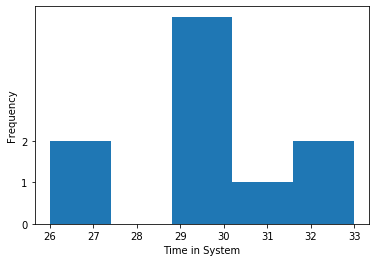

In [9]:
plt.hist(system_time,bins=5)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

Average number in queue: 0.24742268041237114
Max in queue: 3


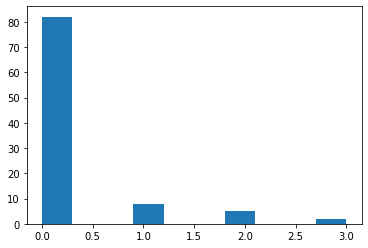

In [22]:
"""
Histogram of queue over time
"""
plt.hist(queue_over_time_kitchen)
print(f"Average number in queue: {np.mean(queue_over_time_kitchen)}")
print(f"Max in queue: {np.max(queue_over_time_kitchen)}")

Average number in queue: 0.5979381443298969
Max in queue: 3


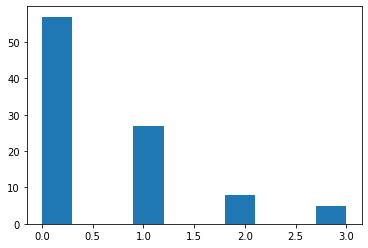

In [23]:
plt.hist(queue_over_time_dining_room)
print(f"Average number in queue: {np.mean(queue_over_time_dining_room)}")
print(f"Max in queue: {np.max(queue_over_time_dining_room)}")

In [11]:
print(f"max system time {np.max(system_time)}")
# 50th percentile, or median
print(f"50th percentile time {np.percentile(system_time,50)}")
print(f"std system time {np.std(system_time)}")

max system time 86
50th percentile time 56.5
std system time 18.601075237738275
